## Simple test with IBTrACS dataset

We select time series of a certain number of parameters of interest from IBTrACS (say n = 8 parameters). The goal is to make an accurate prediction of these n parameters using time series of IBTrACS that would be available only in low resolution observations (that is, without Vmax, Rmax, R64 and R50).


In [1]:
# General
# import glob
# import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils as du

# Statistics
from sklearn import linear_model

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### PARAMS
PARAMS = {'time_steps_input': 2, # length of the input time series used to predict y(t)
          'save_figs': False    
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc',
    # Save
}

### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'nature']

In [3]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
ds_ibt_raw

<xarray.Dataset>
Dimensions:           (storm: 2293, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [4]:
### FILTERS
# By latitude
ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 30, drop=True)
# By year
start_date = np.datetime64('2000-01-01')
ds_ibt     = ds_ibt.where(ds_ibt['time'] - start_date >= np.timedelta64(0, 's'), drop=True)
# By removing empty Rmax time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_rmw'].notnull().sum(axis=1) > 5, drop=True)
# By removing empty R34 time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].notnull().sum(axis=1) > 5, drop=True) 
# By agency
ds_ibt     = ds_ibt.where(ds_ibt['usa_agency'] == b'hurdat_atl', drop=True)

In [5]:
ds_ibt

<xarray.Dataset>
Dimensions:     (storm: 236, date_time: 139, quadrant: 4)
Coordinates:
    time        (storm, date_time) datetime64[ns] 2001-08-02T12:00:00.0000404...
    lat         (storm, date_time) float32 25.7 25.98 26.2 26.32 ... nan nan nan
    lon         (storm, date_time) float32 -84.8 -84.79 -84.9 ... nan nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon     (storm, date_time, quadrant) float32 -84.8 -84.8 ... nan nan
    usa_lat     (storm, date_time, quadrant) float32 25.7 25.7 25.7 ... nan nan
    usa_wind    (storm, date_time, quadrant) float32 30.0 30.0 30.0 ... nan nan
    usa_r34     (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
    usa_rmw     (storm, date_time, quadrant) float32 50.0 50.0 50.0 ... nan nan
    numobs      (storm, date_time, quadrant) float32 48.0 48.0 48.0 ... nan nan
    sid         (storm, date_time, quadrant) object b'2001215N26275' ... nan
    basin       (storm, date_time, quadrant) object b'NA' b'NA' ... nan nan
    name        (storm, date_time, quadrant) object b'BARRY' b'BARRY' ... nan
    usa_agency  (storm, date_time, quadrant) object b'hurdat_atl' ... nan
    iso_time    (storm, date_time, quadrant) object b'2001-08-02 12:00:00' .....
    nature      (storm, date_time, quadrant) object b'TS' b'TS' ... nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [6]:
LR_variables = ['usa_lon', 'usa_lat', 'usa_r34']
ds_ibt_LR    = ds_ibt[LR_variables]
ds_ibt_LR

<xarray.Dataset>
Dimensions:  (storm: 236, date_time: 139, quadrant: 4)
Coordinates:
    time     (storm, date_time) datetime64[ns] 2001-08-02T12:00:00.000040448 ...
    lat      (storm, date_time) float32 25.7 25.98 26.2 26.32 ... nan nan nan
    lon      (storm, date_time) float32 -84.8 -84.79 -84.9 ... nan nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon  (storm, date_time, quadrant) float32 -84.8 -84.8 -84.8 ... nan nan
    usa_lat  (storm, date_time, quadrant) float32 25.7 25.7 25.7 ... nan nan nan
    usa_r34  (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [7]:
### FIRST WE AVERAGE OVER EVERY QUADRANT
PARAMS['time_steps_input']

X = [] # shape (n_samples, n_features)
y = [] # shape (n_samples, n_targets)

for s in tqdm(range(len(ds_ibt.storm))):
    # Select storm
    ds = ds_ibt.isel(storm=s)
    # Get only valid stime steps
    ds = ds[params_of_interest].mean(dim='quadrant', skipna=True)
    ds = ds.dropna(dim='date_time', subset=params_of_interest)
    
    # Add predictors and targets to the global dataset
    for i in range(len(ds.date_time) - PARAMS['time_steps_input']): # When it's negative, code doesn't enter the for loop
        ds_sub = ds.isel(date_time=slice(i, i + PARAMS['time_steps_input']))
        X_current = []
        y_current = []
        for param in params_of_interest:
            y_current.append(float(ds.isel(date_time=i + PARAMS['time_steps_input'])[param])) # target
            for e in ds_sub[param].values:
                X_current.append(e) # inputs
        X.append(X_current)
        y.append(y_current)
        
print('Shape of predictors matrix X: ', np.asarray(X).shape)
print('Shape of targets matrix y: ', np.asarray(y).shape)
# STRUCTURE OF X_current
# [usa_lon(t-4), usa_lon(t-3), usa_lon(t-2), ...., usa_rmw(t-3), usa_rmw(t-2), usa_rmw(t-1)] in the same way like params_of_interest
# e.g params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw']
# STRUCTURE OF y
# [usa_lon(t), usa_lat(t), usa_wind(t), usa_r34(t), usa_rmw(t)]

100%|█████████████████████████████████████████| 236/236 [00:04<00:00, 52.49it/s]

Shape of predictors matrix X:  (3590, 10)
Shape of targets matrix y:  (3590, 5)


In [8]:
# for k in range(5):
#     plt.plot(X[k][-4:])

In [9]:
### FIT LASSO
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X, y)

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 262.7164418825123, tolerance: 132.2541419361854
  model = cd_fast.enet_coordinate_descent(
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1561.5382825217675, tolerance: 721.8094296218229
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

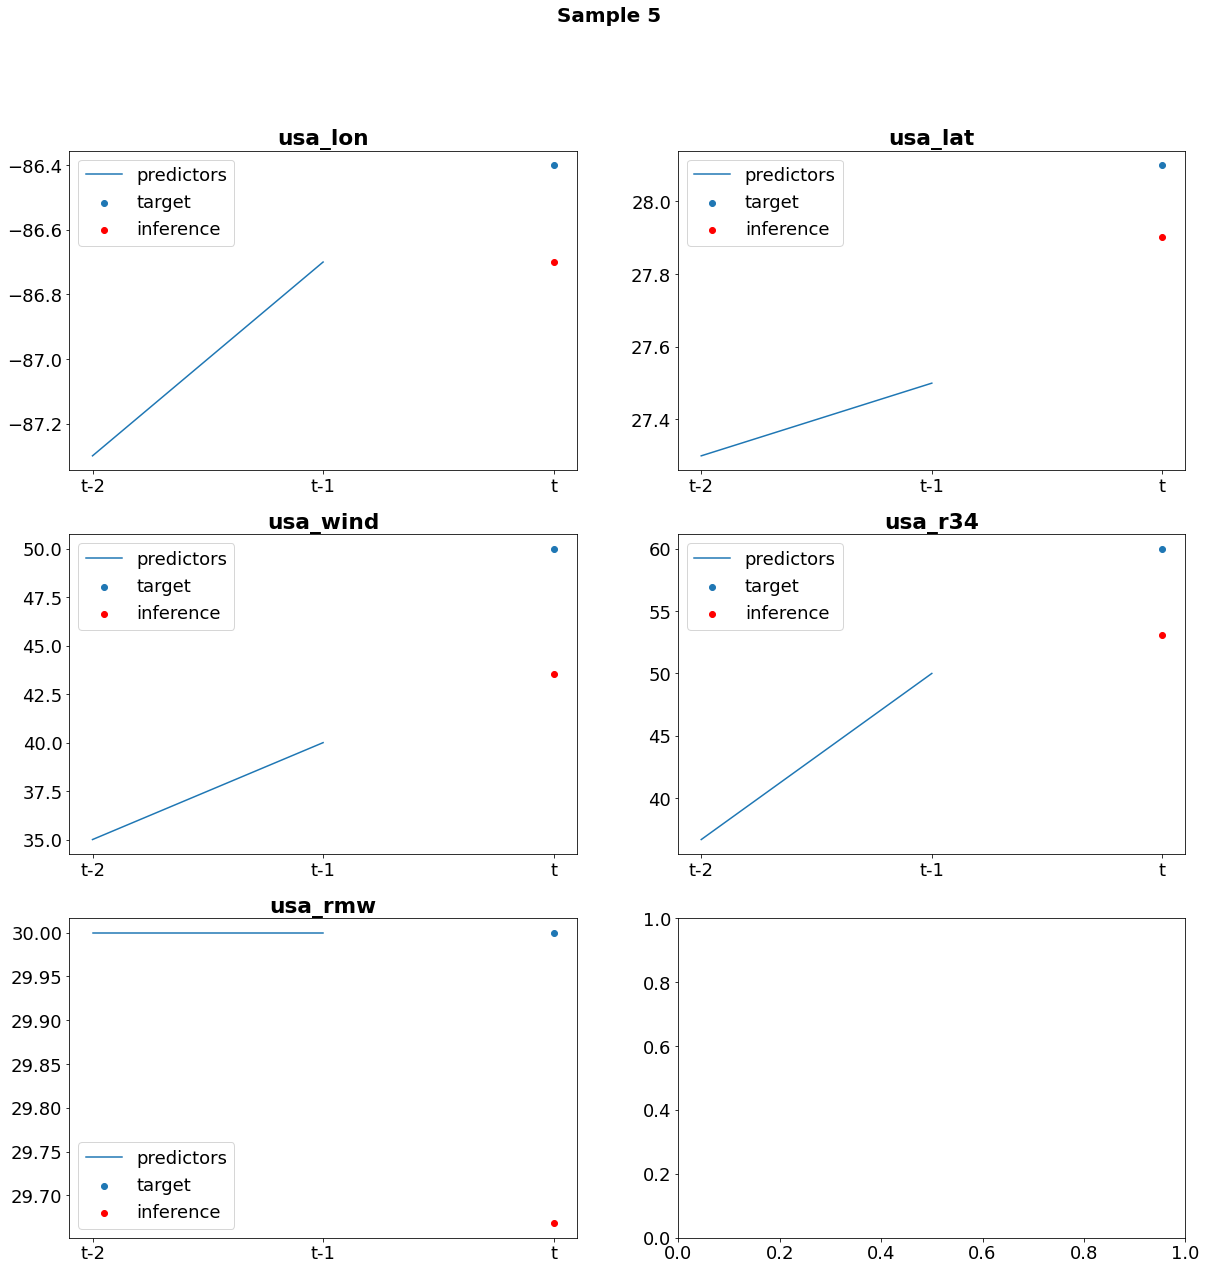

In [10]:
### PLOT ONE SAMPLE INFERENCE PHASE
# k          = 0 # index of sample to test

for k in range(5, 6):
    (fig, axs) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
    xaxis      = np.arange(PARAMS['time_steps_input'] + 1)
    a          = [str(e) for e in (xaxis - PARAMS['time_steps_input'])]
    b          = ['t' for e in range(PARAMS['time_steps_input'] + 1)]
    ticks      = [b[i] + a[i] for i in range(len(b) - 1)] + b[-1:]
    fig.suptitle('Sample %i'%k, fontsize=20, weight='bold')

    for i, ax in enumerate(axs.flatten()[:-1]):
        # Predictors
        j = i * PARAMS['time_steps_input']
        ax.plot(np.asarray(X)[k, j:j + PARAMS['time_steps_input']], label='predictors')

        # Target
        ax.scatter(PARAMS['time_steps_input'], np.asarray(y)[k, i], label='target')

        # Inference
        ax.scatter(PARAMS['time_steps_input'], clf.predict(X[k:k + 1])[0, i], label='inference', c='r')

        # Figure
        ax.set_title(params_of_interest[i], weight='bold')
        ax.set_xticks(xaxis, ticks)
        ax.legend()

Storm name:  b'FAY'
Storm ID:  b'2008229N18293'


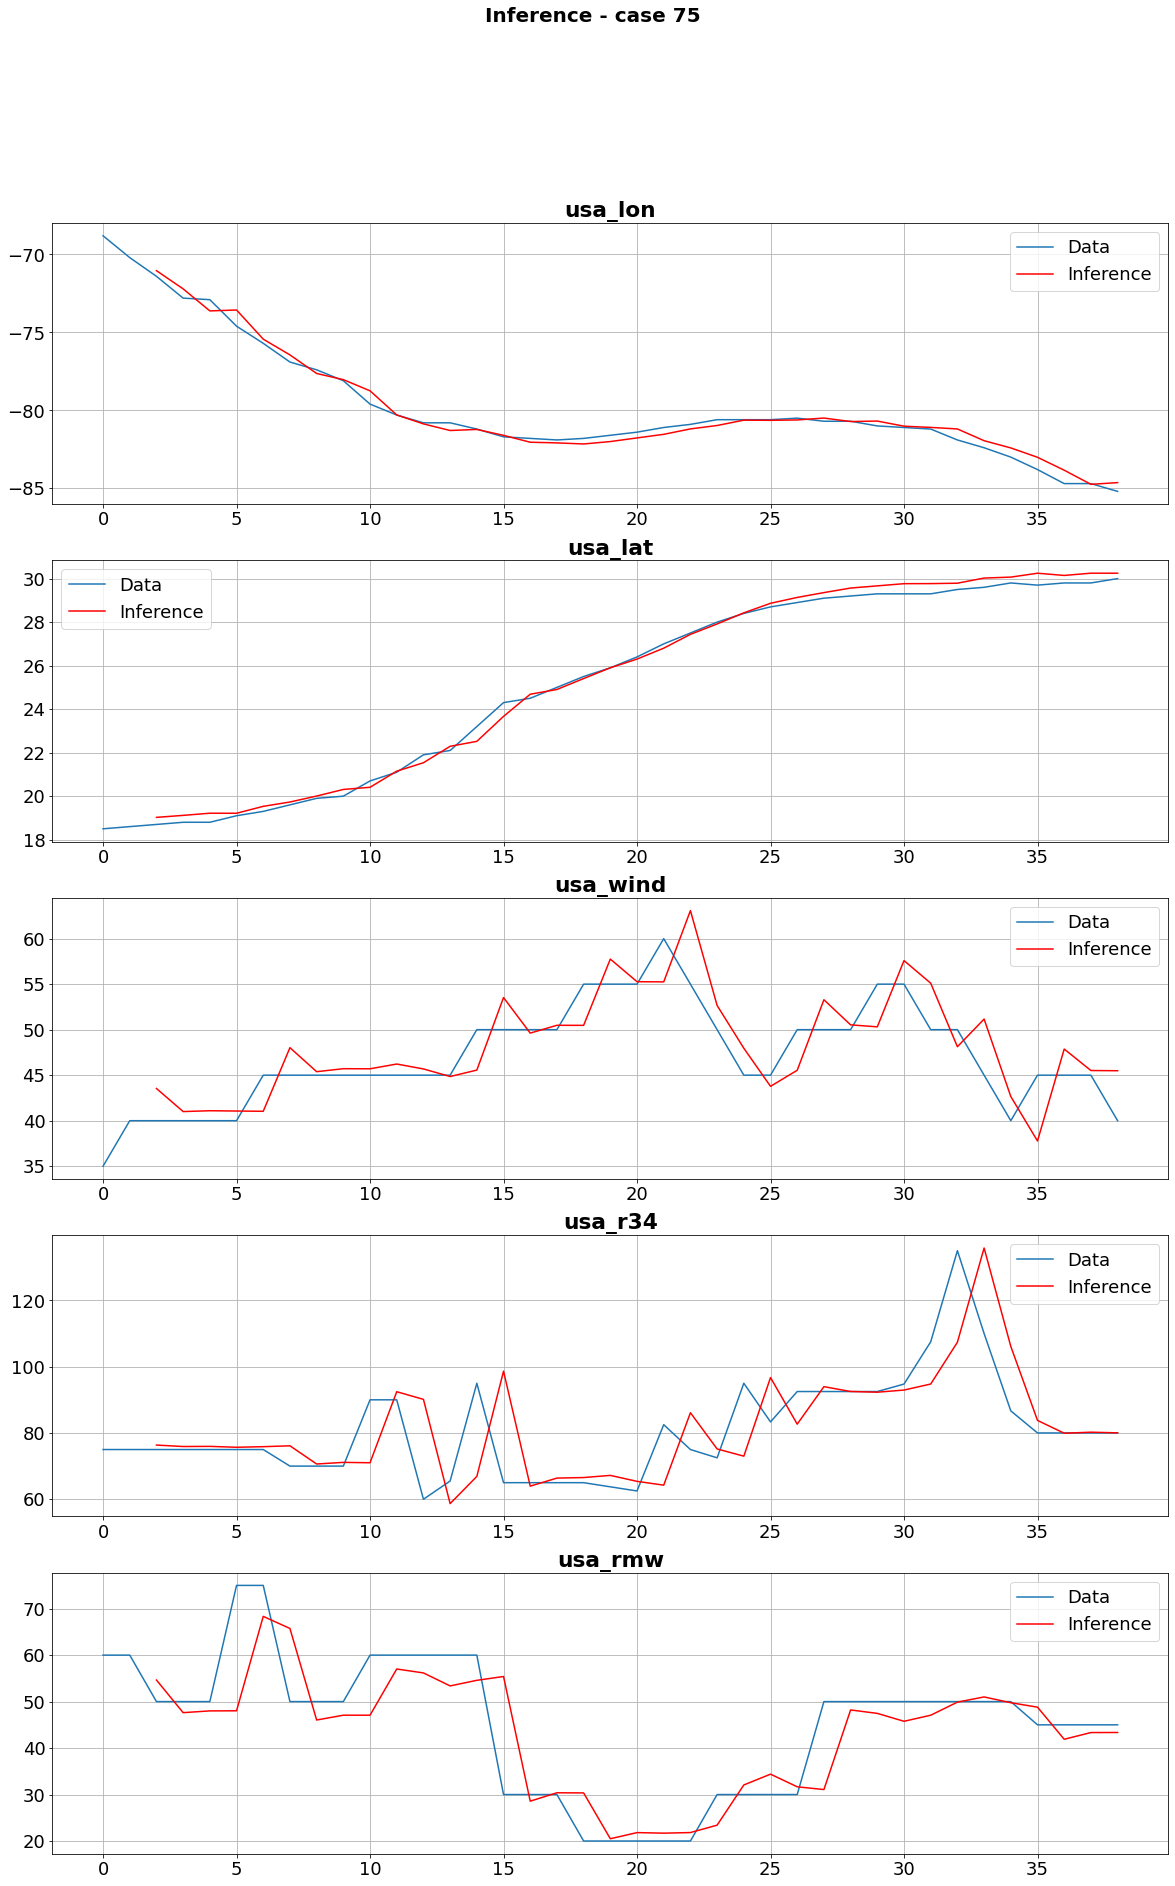

In [11]:
### INFERENCE ON ILLUSTRATIVE CASES
# Select storm
s  = 75 # 75, 80, 120, 130
ds = ds_ibt.isel(storm=s)
print('Storm name: ', str(ds_ibt.isel(storm=s)['name'][0][0].values))
print('Storm ID: ', str(ds_ibt.isel(storm=s)['sid'][0][0].values))
# Get only valid stime steps
ds = ds[params_of_interest].mean(dim='quadrant', skipna=True)
ds = ds.dropna(dim='date_time', subset=params_of_interest)
ds


# Prepare inference input
X_inference = [] 
for i in range(len(ds.date_time) - PARAMS['time_steps_input']):
    ds_sub = ds.isel(date_time=slice(i, i + PARAMS['time_steps_input']))
    X_current = []
    for param in params_of_interest:
        y_current.append(float(ds.isel(date_time=i + PARAMS['time_steps_input'])[param])) # target
        for e in ds_sub[param].values:
            X_current.append(e) # inputs
    X_inference.append(X_current)
    
    
# Plot
(fig, axs) = plt.subplots(nrows=5, ncols=1, figsize=(20, 30))
xaxis      = np.arange(len(ds.date_time))
fig.suptitle('Inference - case %i'%s, fontsize=20, weight='bold')

for i, ax in enumerate(axs.flatten()):
    # Data
    ax.plot(xaxis, ds[params_of_interest[i]], label='Data')
    
    # Inference
    ax.plot(xaxis[PARAMS['time_steps_input']:], clf.predict(X_inference)[:, i], label='Inference', c='r')

    # Figure
    ax.set_title(params_of_interest[i], weight='bold')
    # ax.set_xticks(xaxis)
    ax.grid()
    ax.legend()